**5 - Decision Trees Implementations**

In [15]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import sklearn.preprocessing
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import pydl85
from pydl85 import DL85Classifier
from sklearn.metrics import confusion_matrix

*(a) Simple Decision Tree Construction*

I'd choose a depth of 5 for the final model: there's a large spike in the performance of the model for all three metrics for depth = 5 and it isn't higher anywhere else for any metric. We note that this is the case when we have splitter = 'best'. Splitter = 'random' gives us the best performance at depth = 4. I plot both. We use Gini as the splitting criterion. We'll find out which splitting criterion is best in (b). We don't need to normalize data because we're using decision trees.

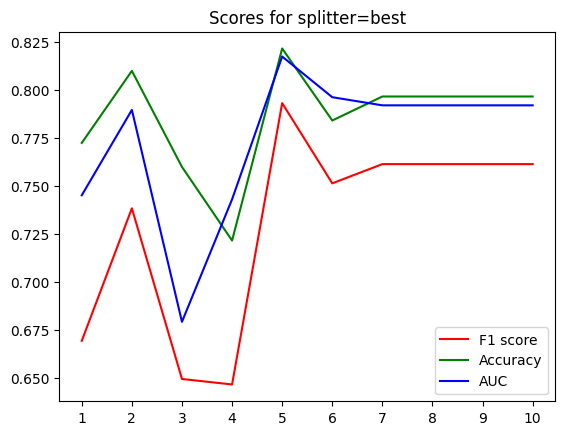

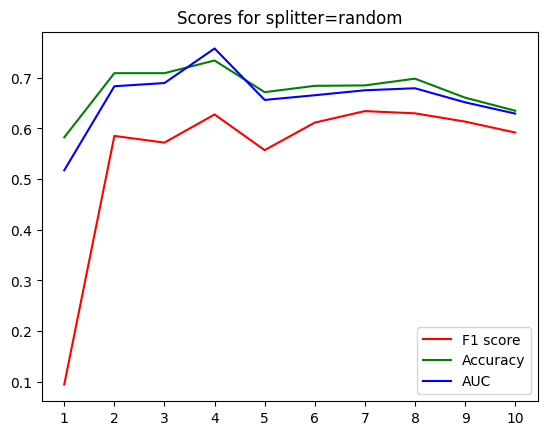

In [2]:
df = pd.read_csv("C:/Users/zachb/Downloads/kindey stone urine analysis.csv")
# Shuffling the data
np.random.seed(42)
df = df.sample(frac=1).reset_index(drop=True)
data = df.drop("target", axis = 1)
target = df["target"]
depths = [1,2,3,4,5,6,7,8,9,10]
f1 = []
acc = []
AUC = []

for depth in depths:
    clf = sk.tree.DecisionTreeClassifier(max_depth = depth, splitter='best', random_state=42)
    f1.append(np.average(cross_val_score(clf, data, target, scoring='f1', cv=5)))
    acc.append(np.average(cross_val_score(clf, data, target, scoring='accuracy', cv=5)))
    AUC.append(np.average(cross_val_score(clf, data, target, scoring='roc_auc', cv=5)))

plt.plot(depths,f1, 'r')
plt.plot(depths,acc,'g')
plt.plot(depths,AUC,'b')
plt.xticks(depths)
plt.legend(['F1 score','Accuracy',"AUC"])
plt.title("Scores for splitter=best")
plt.show()

f1 = []
acc = []
AUC = []
for depth in depths:
    clf = sk.tree.DecisionTreeClassifier(max_depth = depth, splitter='random', random_state=42)
    f1.append(np.average(cross_val_score(clf, data, target, scoring='f1', cv=5)))
    acc.append(np.average(cross_val_score(clf, data, target, scoring='accuracy', cv=5)))
    AUC.append(np.average(cross_val_score(clf, data, target, scoring='roc_auc', cv=5)))

plt.plot(depths,f1, 'r')
plt.plot(depths,acc,'g')
plt.plot(depths,AUC,'b')
plt.xticks(depths)
plt.legend(['F1 score','Accuracy',"AUC"])
plt.title("Scores for splitter=random")
plt.show()



*(b) Traditional Decision Tree Plotting*

We'll use accuracy as the evaluation metric (default metric for the Decision Tree Classifier). The hyperparameters to tune are max_depth, splitter, and criterion. We set the random state inside the parameter grid to 42 for reproducability. Not doing this results in different trees being spawned each time the code is run.

0.6875


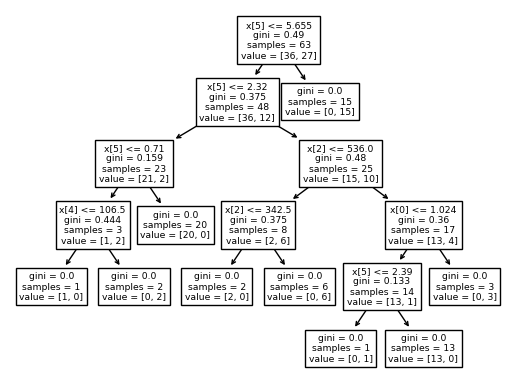

In [14]:
df = pd.read_csv("C:/Users/zachb/Downloads/kindey stone urine analysis.csv")
data = df.drop("target", axis = 1)
target = df["target"]

# Set up the inputs for GridSearchCV

param_grid = {"criterion":['gini', 'entropy',"log_loss"],"splitter":['best','random'],'max_depth':[1,2,3,4,5,6,7,8,9,10], "random_state": [42]}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5)
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=.2, stratify=target, random_state=42)
best_params = clf.fit(data_train, target_train)

model = sk.tree.DecisionTreeClassifier(**best_params.best_params_)
tree = model.fit(data_train,target_train)
score = model.fit(data_train, target_train).score(data_test, target_test)
# We note that changing random_state changes accuracy by a good amount: I had one where changing the random state bumped by accuracy by more than .15!
sk.tree.plot_tree(tree)
print(score)

*(c) Modern Decision Tree Construction*

We use DL85. It takes excruciatingly long to test larger depths (my PC (the worst ACER laptop ever) can't handle 10) so we only go up to depth 4 for our tests. I'll note that I don't think cross_val_scores interacts with DL85 very well. My F1 scores are heinously low when computed through cross_val_scores but fine when I do them by hand. It could be a fluke. I leave it because the DL85 docs explicitly use the scores gotten from cross_val_scores.

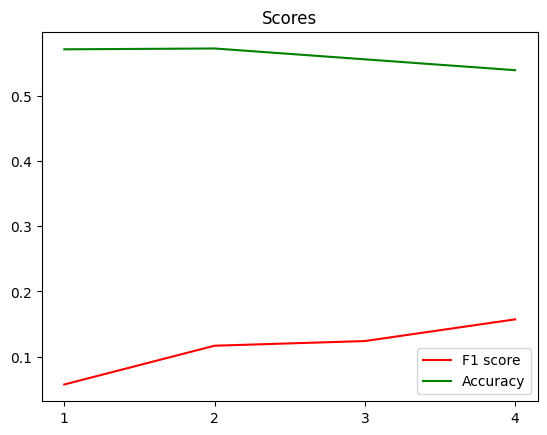

In [18]:
# Binarizing by hand with deciles: like quantiles but 11 ranges instead. The GOSDT package is terminally uncooperative.
# The following code is grindy. Just know that I'm malding through doing this manually. That's all thaty's happening here.
# We're going to create features for each range that's 1 if the value is in the range and zero otherwise
# So we'll have 10 x 6 binary features

df = pd.read_csv("C:/Users/zachb/Downloads/kindey stone urine analysis.csv")
labels = df['target']

# Sorting for the cutoffs

df = df.sort_values(by=["gravity"])

# Getting cutoffs for the feature to create 10 ranges for new binary features

f1 = np.array_split(df.iloc[0:,0],10)
f1_cutoffs = []
for deciles in f1:
    f1_cutoffs.append(deciles.iloc[-1])
# f1_cutoffs

df = df.sort_values(by=["ph"])
f2 = np.array_split(df.iloc[0:,1],10)
f2_cutoffs = []
for deciles in f2:
    f2_cutoffs.append(deciles.iloc[-1])
# f2_cutoffs

df = df.sort_values(by=["osmo"])
f3 = np.array_split(df.iloc[0:,2],10)
f3_cutoffs = []
for deciles in f3:
    f3_cutoffs.append(deciles.iloc[-1])
# f3_cutoffs

df = df.sort_values(by=["cond"])
f4 = np.array_split(df.iloc[0:,3],10)
f4_cutoffs = []
for deciles in f4:
    f4_cutoffs.append(deciles.iloc[-1])
# f4_cutoffs

df = df.sort_values(by=["urea"])
f5 = np.array_split(df.iloc[0:,4],10)
f5_cutoffs = []
for deciles in f5:
    f5_cutoffs.append(deciles.iloc[-1])
# f5_cutoffs

df = df.sort_values(by=["calc"])
f6 = np.array_split(df.iloc[0:,5],10)
f6_cutoffs = []
for deciles in f6:
    f6_cutoffs.append(deciles.iloc[-1])

df = pd.read_csv("C:/Users/zachb/Downloads/kindey stone urine analysis.csv")

# A function that takes in the column index as an input and outputs the array of thresholds for the new features

def cutoffmarker(j):
    if j==0:
        return f1_cutoffs
    if j==1:
        return f2_cutoffs
    if j==2:
        return f3_cutoffs
    if j==3:
        return f4_cutoffs
    if j==4:
        return f5_cutoffs
    if j==5:
        return f6_cutoffs

# What will become our new dataframe

data = []

# Splitting the continuous features into 60 binary features

for i in range(79):
    values = []
    for j in range(6):
        ansatz = [0,0,0,0,0,0,0,0,0,0]
        if df.iloc[i,j] < cutoffmarker(j)[0]:
            ansatz[0] = 1 
        if df.iloc[i,j] < cutoffmarker(j)[1] and df.iloc[i,j] > cutoffmarker(j)[0]:
            ansatz[1] = 1 
        if df.iloc[i,j] < cutoffmarker(j)[2] and df.iloc[i,j] > cutoffmarker(j)[1]:
            ansatz[2] = 1 
        if df.iloc[i,j] < cutoffmarker(j)[3] and df.iloc[i,j] > cutoffmarker(j)[2]:
            ansatz[3] = 1 
        if df.iloc[i,j] < cutoffmarker(j)[4] and df.iloc[i,j] > cutoffmarker(j)[3]:
            ansatz[4] = 1 
        if df.iloc[i,j] < cutoffmarker(j)[5] and df.iloc[i,j] > cutoffmarker(j)[4]:
            ansatz[5] = 1 
        if df.iloc[i,j] < cutoffmarker(j)[6] and df.iloc[i,j] > cutoffmarker(j)[5]:
            ansatz[6] = 1 
        if df.iloc[i,j] < cutoffmarker(j)[7] and df.iloc[i,j] > cutoffmarker(j)[6]:
            ansatz[7] = 1 
        if df.iloc[i,j] < cutoffmarker(j)[8] and df.iloc[i,j] > cutoffmarker(j)[7]:
            ansatz[8] = 1 
        if df.iloc[i,j] < cutoffmarker(j)[9] and df.iloc[i,j] > cutoffmarker(j)[8]:
            ansatz[9] = 1 
        values.extend(ansatz)
    data.append(values)
data = np.array(data)
data = np.hsplit(data,1)
data = np.squeeze(data)
data = pd.DataFrame(data)
# data.insert(60, 'target', labels)
data

depths = [1,2,3,4]
f1 = []
acc = []
# AUC = []

data_train, data_test, target_train, target_test = train_test_split(data, labels, test_size=.2, stratify=labels, random_state=42)

for depth in depths:
    clf = DL85Classifier(max_depth = depth)
    f1.append(np.average(cross_val_score(clf, data_train, target_train, scoring='f1', cv=5)))
    acc.append(np.average(cross_val_score(clf, data_train, target_train, scoring='accuracy', cv=5)))

# For AUC we calculate 

plt.plot(depths,f1, 'r')
plt.plot(depths,acc,'g')
# plt.plot(depths,AUC,'b')
plt.xticks(depths)
plt.legend(['F1 score','Accuracy',"AUC"])
plt.title("Scores")
plt.show()

This is the accuracy score for DL85 after tuning max_depth

In [12]:
param_grid = {'max_depth':[1,2,3,4]}
classy = GridSearchCV(clf, param_grid, cv = 5, scoring='f1')
best_params = classy.fit(data_train, target_train)

model = DL85Classifier(**best_params.best_params_)
tree = model.fit(data_train,target_train)
score = model.fit(data_train, target_train).score(data_test, target_test)
print(model.accuracy_)

0.857143


This is the f1 score for DL85 after tuning max_depth

In [17]:
y_pred = tree.predict(data_test)
print(confusion_matrix(target_test,y_pred))
precision = 6/8 
recall = 6/9
f1score = 2*(precision*recall)/(precision+recall) 
print(f1score)

[[6 3]
 [2 5]]
0.7058823529411765


*(d) Model Comparison*

It looks like DL85 had much better accuracy (.85ish) than the regular sklearn.DecisionTreeClassifier (.69ish). They have similar F1 scores with DL85 winning by about .06.

In [21]:
# This is computing the F1 score for the decision tree classifier. We computed the accuracy in (b) despite not needing to.

param_grid = {"criterion":['gini', 'entropy',"log_loss"],"splitter":['best','random'],'max_depth':[1,2,3,4,5,6,7,8,9,10], "random_state": [42]}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5)
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=.2, stratify=target, random_state=42)
best_params = clf.fit(data_train, target_train)

model = sk.tree.DecisionTreeClassifier(**best_params.best_params_)
tree = model.fit(data_train,target_train)

y_pred = tree.predict(data_test)
print(confusion_matrix(target_test,y_pred))
precision = 7/11 
recall = 7/9
f1score = 2*(precision*recall)/(precision+recall) 
print(f1score)

[[7 2]
 [4 3]]
0.7000000000000001
